In [1]:
from tqdm import tqdm

# Generate dataset

# Analysis

## Load the results

In [2]:
import pandas as pd
from ast import literal_eval


# Load the CSV file
df = pd.read_csv('game_results.csv')


df['Past words player 1'] = df['Past words player 1'].apply(literal_eval)
df['Past words player 2'] = df['Past words player 2'].apply(literal_eval)


## Models-pairs performances

In [3]:
# Create a new column 'Model Pair' treating the model combinations symmetrically
df['Model Pair'] = df.apply(lambda row: tuple(sorted([row['Model 1'], row['Model 2']])), axis=1)


# Compute success rate for all games
df['Win'] = df['Status'].apply(lambda x: 'wins' in x)
success_rate = df.groupby('Model Pair').agg(Success_Rate=('Win', 'mean'))

# Filter only the rows where the status is 'wins'
wins_df = df[df['Status'] == 'wins']
wins_df['Round Length 1'] = wins_df['Past words player 1'].apply(len)
wins_df['Round Length 2'] = wins_df['Past words player 2'].apply(len)
wins_df['Average Round Length'] = (wins_df['Round Length 1'] + wins_df['Round Length 2']) / 2  # Average both players' rounds

# Group by 'Model Pair' and compute the average rounds for winning games
avg_rounds = wins_df.groupby('Model Pair').agg(Average_Rounds=('Average Round Length', 'mean'))

# Merge success rate and average rounds into one result
result = success_rate.merge(avg_rounds, on='Model Pair')
print(result)

                                          Success_Rate  Average_Rounds
Model Pair                                                            
(gpt-3.5-turbo-0125, gpt-3.5-turbo-0125)         0.750        4.600000
(gpt-3.5-turbo-0125, gpt-4-turbo)                0.500        4.650000
(gpt-3.5-turbo-0125, gpt-4o-mini)                0.600        5.125000
(gpt-4-turbo, gpt-4-turbo)                       1.000        3.350000
(gpt-4-turbo, gpt-4o-mini)                       0.825        7.030303
(gpt-4o-mini, gpt-4o-mini)                       0.900        6.055556


/var/folders/c9/p_q1xbbj7sv7nwvd_17c75lh0000gn/T/ipykernel_28784/398347082.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wins_df['Round Length 1'] = wins_df['Past words player 1'].apply(len)
/var/folders/c9/p_q1xbbj7sv7nwvd_17c75lh0000gn/T/ipykernel_28784/398347082.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wins_df['Round Length 2'] = wins_df['Past words player 2'].apply(len)
/var/folders/c9/p_q1xbbj7sv7nwvd_17c75lh0000gn/T/ipykernel_28784/398347082.py:13: SettingWithCopyWarning: 
A value i

## Visualise convergence

In [4]:
from importlib import reload
import embeding_visualization
reload(embeding_visualization)
from embeding_visualization import get_embeddings
import matplotlib.pyplot as plt

from scipy.spatial.distance import euclidean
import numpy as np


# Initialize dictionary to hold distances by model combination
model_combinations = {}
rounds = 6  # Calculate for the last 3 rounds, adapt as needed
color_index = 0  # Initialize color index

# Calculate embeddings and distances
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    if row['Status'] == "wins": 
        embeddings_1 = get_embeddings(row['Past words player 1'][-rounds:])
        embeddings_2 = get_embeddings(row['Past words player 2'][-rounds:])
        if len(embeddings_1) >= rounds:
            row_distances = [euclidean(embeddings_1[i], embeddings_2[i]) for i in range(min(len(embeddings_1), len(embeddings_2)))]
            # Generate both model keys (Model 1 vs Model 2 and vice versa)
            model_key = (row['Model 1'], row['Model 2'])
            reverse_model_key = (row['Model 2'], row['Model 1'])

            # Check if either model_key or reverse_model_key exists
            if model_key in model_combinations:
                model_combinations[model_key].append(row_distances)
            elif reverse_model_key in model_combinations:
                model_combinations[reverse_model_key].append(row_distances)
            else:
                model_combinations[model_key] = [row_distances]


100%|██████████| 180/180 [06:27<00:00,  2.15s/it]


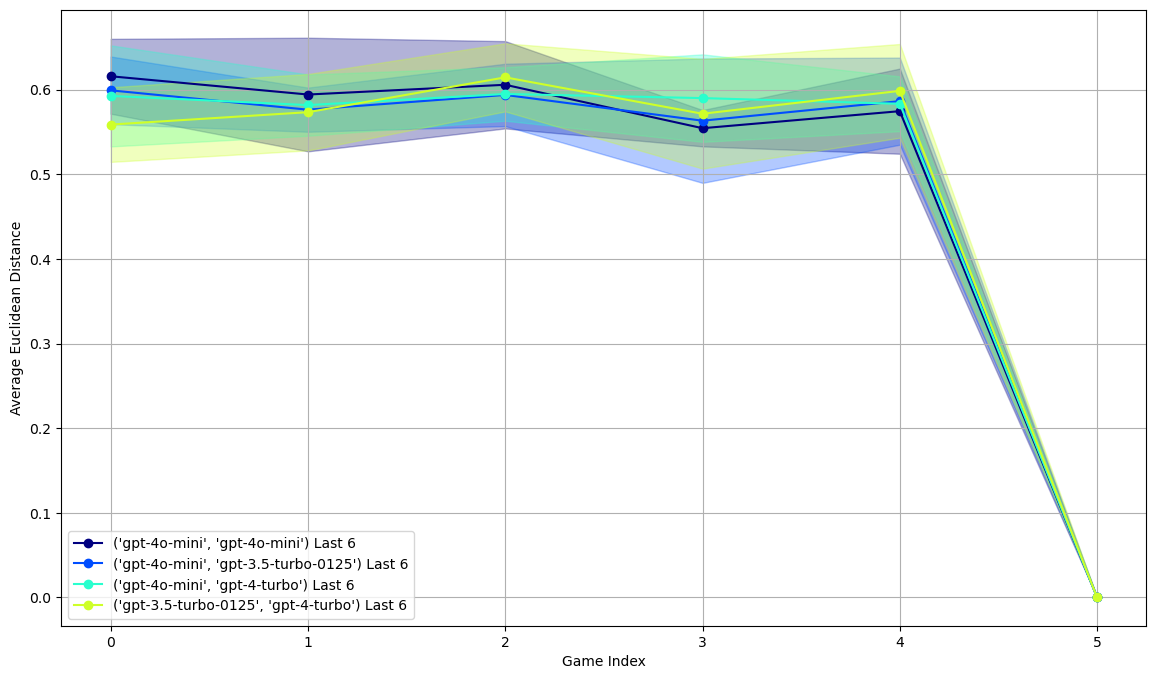

In [5]:

# Calculate and plot mean and std for the last few rounds for combinations with enough data
plt.figure(figsize=(14, 8))
colors = plt.cm.jet(np.linspace(0, 1, len(model_combinations)))

color_index = 0  # Initialize color index
for (model_key, distances_lists) in model_combinations.items():
    if len(distances_lists) >= rounds:
        # Calculate the mean and standard deviation for the last few rounds
        last_games = distances_lists[-rounds:]  # Get the last 'rounds' games
        last_games_array = np.array(last_games)
        
        # Calculating mean and std dev for the required rounds
        mean_of_last_games = np.mean(last_games_array, axis=0)
        std_of_last_games = np.std(last_games_array, axis=0)
        
        # Create time index for the rounds
        time_index = np.arange(rounds)

        # Plotting mean line
        plt.plot(time_index, mean_of_last_games, label=f'{model_key} Last {rounds}', marker='o', color=colors[color_index])
        
        # Plotting the std deviation area around the mean
        plt.fill_between(time_index, mean_of_last_games - std_of_last_games, mean_of_last_games + std_of_last_games, color=colors[color_index], alpha=0.3)
        
        color_index += 1  # Increment color index for the next model combination

plt.xlabel('Game Index')
plt.ylabel('Average Euclidean Distance')
plt.legend()
plt.grid(True)
plt.show()

## Comparison to average of two last words

In [8]:
df['Past words player 1'].iloc[tryout]

['Zebra',
 'Cookie',
 'Pillow',
 'Mango',
 'Telescope',
 'Mountain',
 'Starfish',
 'Jungle',
 'Fishbowl',
 'Garden',
 'Coral',
 'Beach',
 'Bayou',
 'Seaside',
 'Wetland']

In [6]:
from importlib import reload
import embeding_visualization
reload(embeding_visualization)
from embeding_visualization import get_embeddings
import numpy as np

tryout = 4

# Retrieving data
words_player1 = df['Past words player 1'].iloc[tryout]
words_player2 = df['Past words player 2'].iloc[tryout]
embeddings_1 = get_embeddings(words_player1)
embeddings_2 = get_embeddings(words_player2)

# Calculating average embeddings
average_embeddings = (np.array(embeddings_1) + np.array(embeddings_2)) / 2

# Ensuring lengths are correct
print("Length of Player 1 embeddings:", len(embeddings_1))
print("Length of Player 2 embeddings:", len(embeddings_2))

Length of Player 1 embeddings: 15
Length of Player 2 embeddings: 15


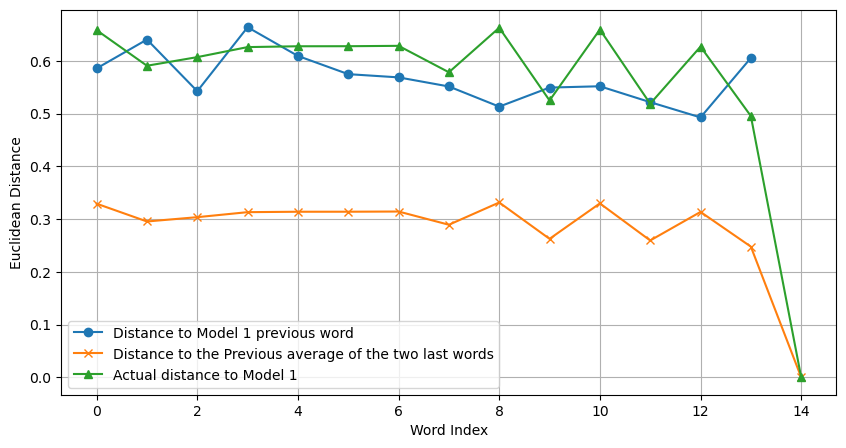

In [7]:
from benchmark.analysis.model_strategy import plot_distances

plot_distances(embeddings_1, embeddings_2, average_embeddings)

### Table for each model

In [ ]:

import pandas as pd
from tqdm import tqdm
from benchmark.analysis.model_strategy import calculate_distances

tqdm.pandas()


# List of models to analyze
models = ["gpt-4-turbo", "gpt-4o-mini", "gpt-3.5-turbo-0125"]

# Initialize a list to store the results
results = []

for model in models:
    # Filter the data where 'Status' is 'wins' or 'loses, too many rounds' and the model is either Model 1 or Model 2
    model_results = df[
    #        ((df['Status'] == 'wins') | (df['Status'] == 'loses, too many rounds')) &
        (df['Status'] == 'loses, too many rounds') &
        ((df['Model 1'] == model) | (df['Model 2'] == model))
    ].copy()
    
    # Determine which player corresponds to the current model
    def assign_past_words(row):
        if row['Model 1'] == model:
            row['Past words current Model'] = row['Past words player 1']
            row['Past words other Model'] = row['Past words player 2']
        else:
            row['Past words current Model'] = row['Past words player 2']
            row['Past words other Model'] = row['Past words player 1']
        return row

    model_results = model_results.apply(assign_past_words, axis=1)
    
    # Apply the function to each row and store the results
    calculated_distances = model_results.progress_apply(lambda row: calculate_distances(row), axis=1)
    
    # Split the results into two separate lists for each row
    model_results['Distances to Previous'] = calculated_distances.apply(lambda x: x[0])
    model_results['Distances to Average'] = calculated_distances.apply(lambda x: x[1])
    
    # Calculate the average distance for both 'Distances to Previous' and 'Distances to Average'
    model_results['Average Distance to Previous'] = model_results['Distances to Previous'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)
    model_results['Average Distance to Average'] = model_results['Distances to Average'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)
    
    # Compute the overall mean of the average distances
    mean_distance_to_previous = model_results['Average Distance to Previous'].mean()
    mean_distance_to_average = model_results['Average Distance to Average'].mean()
    
    # Determine the strategy
    if mean_distance_to_previous < mean_distance_to_average:
        strategy = "Mirroring Strategy"
    else:
        strategy = "Balancing Strategy"
    
    # Append the results to the list
    results.append({
        "Model": model,
        "Mean Distance to Previous": mean_distance_to_previous,
        "Mean Distance to Average": mean_distance_to_average,
        "Predominant Strategy": strategy
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results in a table
print(results_df)

## Dynamics visualization

In [ ]:
from benchmark.analysis.visualization import create_fixed_color_lines

### Gpt4-mini lost

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA

tryout = 2

words_player1 = df['Past words player 1'].iloc[tryout]
words_player2 = df['Past words player 2'].iloc[tryout]
embeddings_1 = get_embeddings(df['Past words player 1'].iloc[tryout])
embeddings_2 = get_embeddings(df['Past words player 2'].iloc[tryout])


# merge the embeddings
embeddings = embeddings_1 + embeddings_2

# Use PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
pca_result = pca.fit(np.array(embeddings))
reduced_embeddings_1 = pca.transform(embeddings_1)
reduced_embeddings_2 = pca.transform(embeddings_2)

# Create 3D scatter plot for player 1 and player 2
trace1 = go.Scatter3d(
    x=reduced_embeddings_1[:, 0],
    y=reduced_embeddings_1[:, 1],
    z=reduced_embeddings_1[:, 2],
    mode='markers+text',
    marker=dict(size=4, color='blue'),
    text=np.arange(len(words_player1)),
    name='Model 1'
)

trace2 = go.Scatter3d(
    x=reduced_embeddings_2[:, 0],
    y=reduced_embeddings_2[:, 1],
    z=reduced_embeddings_2[:, 2],
    mode='markers+text',
    marker=dict(size=4, color='red'),
    text=np.arange(len(words_player2)),
    name='Model 2'
)

if words_player2[-1] == words_player1[-1]:
    print("won")
    # Add the last point as a star for Player 2
    last_point_player = go.Scatter3d(
        x=[reduced_embeddings_2[-1, 0]],
        y=[reduced_embeddings_2[-1, 1]],
        z=[reduced_embeddings_2[-1, 2]],
        mode='markers+text',
        marker=dict(size=8, color='green', symbol="diamond-open"),
        text=[words_player2[-1]],
        name='Final word'
    )


# Create gradient lines for both players using Plotly colormaps
lines_player1 = create_fixed_color_lines(reduced_embeddings_1, len(words_player1), 'blue')
lines_player2 = create_fixed_color_lines(reduced_embeddings_2, len(words_player2), 'red')

# Combine all traces
data = [trace1, trace2] + lines_player1 + lines_player2
if words_player2[-1] == words_player1[-1]:
    data = data + [last_point_player]
# Define layout with larger figure size
layout = go.Layout(
    title='3D Scatter Plot with Colormap Gradient Lines',
    scene=dict(
        xaxis=dict(title='PCA1'),
        yaxis=dict(title='PCA2'),
        zaxis=dict(title='PCA3'),
    ),
    legend_title_text='Models',
    width=800,
    height=800,
)

# Create figure and show
fig = go.Figure(data=data, layout=layout)
fig.show()

### Win between gpt-4-turbo,gpt-4o-mini

In [ ]:
words_player1

In [ ]:
words_player2

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA

tryout = 125

words_player1 = df['Past words player 1'].iloc[tryout]
words_player2 = df['Past words player 2'].iloc[tryout]
embeddings_1 = get_embeddings(df['Past words player 1'].iloc[tryout])
embeddings_2 = get_embeddings(df['Past words player 2'].iloc[tryout])


# merge the embeddings
embeddings = embeddings_1 + embeddings_2

# Use PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
pca_result = pca.fit(np.array(embeddings))
reduced_embeddings_1 = pca.transform(embeddings_1)
reduced_embeddings_2 = pca.transform(embeddings_2)

# Create 3D scatter plot for player 1 and player 2
trace1 = go.Scatter3d(
    x=reduced_embeddings_1[:, 0],
    y=reduced_embeddings_1[:, 1],
    z=reduced_embeddings_1[:, 2],
    mode='markers+text',
    marker=dict(size=4, color='blue'),
    text=np.arange(len(words_player1)),
    name='Model 1'
)

trace2 = go.Scatter3d(
    x=reduced_embeddings_2[:, 0],
    y=reduced_embeddings_2[:, 1],
    z=reduced_embeddings_2[:, 2],
    mode='markers+text',
    marker=dict(size=4, color='red'),
    text=np.arange(len(words_player2)),
    name='Model 2'
)

if words_player2[-1] == words_player1[-1]:
    print("won")
    # Add the last point as a star for Player 2
    last_point_player = go.Scatter3d(
        x=[reduced_embeddings_2[-1, 0]],
        y=[reduced_embeddings_2[-1, 1]],
        z=[reduced_embeddings_2[-1, 2]],
        mode='markers+text',
        marker=dict(size=8, color='green', symbol="diamond-open"),
        text=[words_player2[-1]],
        name='Final word'
    )


# Create gradient lines for both players using Plotly colormaps
lines_player1 = create_fixed_color_lines(reduced_embeddings_1, len(words_player1), 'blue')
lines_player2 = create_fixed_color_lines(reduced_embeddings_2, len(words_player2), 'red')

# Combine all traces
data = [trace1, trace2] + lines_player1 + lines_player2
if words_player2[-1] == words_player1[-1]:
    data = data + [last_point_player]
# Define layout with larger figure size
layout = go.Layout(
    title='3D Scatter Plot with Colormap Gradient Lines',
    scene=dict(
        xaxis=dict(title='PCA1'),
        yaxis=dict(title='PCA2'),
        zaxis=dict(title='PCA3'),
    ),
    legend_title_text='Models',
    width=800,
    height=800,
)

# Create figure and show
fig = go.Figure(data=data, layout=layout)
fig.show()

### Win between gpt-4-turbo

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA

tryout = 175

words_player1 = df['Past words player 1'].iloc[tryout]
words_player2 = df['Past words player 2'].iloc[tryout]
embeddings_1 = get_embeddings(df['Past words player 1'].iloc[tryout])
embeddings_2 = get_embeddings(df['Past words player 2'].iloc[tryout])


# merge the embeddings
embeddings = embeddings_1 + embeddings_2

# Use PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
pca_result = pca.fit(np.array(embeddings))
reduced_embeddings_1 = pca.transform(embeddings_1)
reduced_embeddings_2 = pca.transform(embeddings_2)


# Create 3D scatter plot for player 1 and player 2
trace1 = go.Scatter3d(
    x=reduced_embeddings_1[:, 0],
    y=reduced_embeddings_1[:, 1],
    z=reduced_embeddings_1[:, 2],
    mode='markers+text',
    marker=dict(size=4, color='blue'),
    text=np.arange(len(words_player1)),
    name='Model 1'
)

trace2 = go.Scatter3d(
    x=reduced_embeddings_2[:, 0],
    y=reduced_embeddings_2[:, 1],
    z=reduced_embeddings_2[:, 2],
    mode='markers+text',
    marker=dict(size=4, color='red'),
    text=np.arange(len(words_player2)),
    name='Model 2'
)

if words_player2[-1] == words_player1[-1]:
    print("won")
    # Add the last point as a star for Player 2
    last_point_player = go.Scatter3d(
        x=[reduced_embeddings_2[-1, 0]],
        y=[reduced_embeddings_2[-1, 1]],
        z=[reduced_embeddings_2[-1, 2]],
        mode='markers+text',
        marker=dict(size=8, color='green', symbol="diamond-open"),
        text=[words_player2[-1]],
        name='Final word'
    )


# Create gradient lines for both players using Plotly colormaps
lines_player1 = create_fixed_color_lines(reduced_embeddings_1, len(words_player1), 'blue')
lines_player2 = create_fixed_color_lines(reduced_embeddings_2, len(words_player2), 'red')

# Combine all traces
data = [trace1, trace2] + lines_player1 + lines_player2
if words_player2[-1] == words_player1[-1]:
    data = data + [last_point_player]
# Define layout with larger figure size
layout = go.Layout(
    title='3D Scatter Plot with Colormap Gradient Lines',
    scene=dict(
        xaxis=dict(title='PCA1'),
        yaxis=dict(title='PCA2'),
        zaxis=dict(title='PCA3'),
    ),
    legend_title_text='Models',
    width=800,
    height=800,
)

# Create figure and show
fig = go.Figure(data=data, layout=layout)
fig.show()